Objectives for this notebooks are:
* Fishes invest a % of their available
* Schedule for weights updating

In [1]:
%run _config.ipynb

### Model Methods

In [2]:
def change_Prices(model):
    agent_wealth = [agent.wealth for agent in model.schedule.agents]
    agent_positions = [agent.position for agent in model.schedule.agents]
    agent_orders = [agent.order for agent in model.schedule.agents]
    
    sbo = 0 # sum buy orders
    sso = 0 # sum sell orders
    
    for i in range(len(agent_positions)):
        if agent_positions[i] == 'long':
            sbo += agent_orders[i]
        elif agent_positions[i] == 'short':
            sso += agent_orders[i]
    
    mu = 0.005
    alfa = model.Price * mu # coefficient for price updating
    delta = alfa * (sbo - sso)
    
    if (sbo - sso) < -1./mu: # condition where prices get negative because of self.order being floats and not integers.
        print(f'sbo: {sbo}')
        print(f'sso: {sso}')
        model.Price = 0
        model.Last_Price = 0
    else:
        model.Last_Price = model.Price
        model.Price = model.Price + delta
    
    return model.Price

In [3]:
# INIT WITH Barabàsi-Albert
def get_BA_mapped_edges(N_agents, N_init_edges, labels):
    BA = nx.barabasi_albert_graph(N_agents, N_init_edges)
    list_edges = list(BA.edges())
    
    mapped_edges = list()
    for edge in list_edges:
        node1 = list(labels.keys())[list(labels.values()).index(f'fish_{edge[0]}')]
        node2 = list(labels.keys())[list(labels.values()).index(f'fish_{edge[1]}')]
        mapped_edges.append((node1, node2))
        
    return mapped_edges

In [4]:
def synch_coeff(u, v):
    u_pv = (u.last_wealth - u.wealth)/u.wealth
    v_pv = (v.last_wealth - v.wealth)/v.wealth
    print(f'u stats: {u.last_wealth}, {u.wealth}')
    print(f'u wallet: {u.wallet}')
    
    print(f'v stats: {v.last_wealth}, {v.wealth}')
    print(f'v wallet: {v.wallet}')
    print(f'u_pv: {round(u_pv, 4)}\t v_pv: {round(v_pv, 4)}')
    
    if u_pv > 1:
        u_pv = 1
    if v_pv > 1:
        v_pv = 1
    
    return u_pv*v_pv

def synch_coeff_sign(u, v):
    u_pv = (u.last_wealth - u.wealth)/u.wealth
    v_pv = (v.last_wealth - v.wealth)/v.wealth
    
    if u_pv*v_pv > 0:
        return 0.10
    elif u_pv*v_pv < 0:
        return -0.10
    else:
        return random.uniform(-0.02, 0.02)

### Plot Methods

In [5]:
def get_graphlabels(ordered_dict):
    inv_dict = dict(zip(ordered_dict.values(), ordered_dict.keys()))
    return inv_dict

In [6]:
def plot_graph(schedule):
    G = schedule.net
    pos = nx.spring_layout(G, k = 10)
    labels = get_graphlabels(schedule._agents)

    plt.figure(figsize=(14, 8))
    s = nx.draw_networkx_nodes(
        G,
        pos,
        node_size = 200,
        node_color = list(dict(nx.degree(G)).values()),
        alpha = 1,
        cmap = plt.cm.BuGn
    )
    
    edge_labels = {e: round(G.edges[e]['weight'], 2) for e in G.edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size = 6)
    
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos, labels, font_size=6, bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0.5))

    #show the colorbar on the right side
    cbar = plt.colorbar(s)
    cbar.ax.set_ylabel('Degree', size=12)

    plt.axis('off')
    plt.show();

### General Agent's Methods

In [7]:
def sample_from_dict(dic, n):
    keys = random.sample(list(dic), n)
    return {k: dic[k] for k in keys}

def get_neighbors(dict_agents, agent_id):
    dict_agents.pop(agent_id, None) # always exclude himself from the list before taking the sample
    return sample_from_dict(dict_agents, 2) # take a sample of 1 agent

In [8]:
def add_friends(dict_neighbors, self_node):
    node_neighbors = dict_neighbors.values() # e.g. [<__main__.Agent object at 0x7f64f5ca7910>, <__main__.Agent object at 0x7f64f3ca8110>]
    
    tuple_links = list()
    for neighbour_node in node_neighbors:
        tuple_links.append((self_node, neighbour_node, random.uniform(0.40, 0.60)))
    
    return tuple_links

In [9]:
def remove_friends(G, self_node, trust_thr):
    my_edges = list(G.edges(self_node, data = True))
    
    tuple_links_to_remove = list()
    for edge in my_edges:
        if edge[2]['weight'] < trust_thr: # If weight of friend is less than my desired threshold i remove him from friends list
            tuple_links_to_remove.append((self_node, edge[1]))
    
    return tuple_links_to_remove

In [10]:
def check_socials(G, self_node):
    friends_positions = list()
    friends_trust = list()
    for (u, v) in G.edges(self_node):
        friends_trust.append(G.edges[u, v]['weight'])
        friends_positions.append(v.position)

    df_friends = pd.DataFrame(zip(friends_positions, friends_trust), columns = ['pos', 'trust'])
    
    points = list()
    pos = ['null', 'long', 'short']
    for p in pos:
        points.append(df_friends[ df_friends['pos'] == p ]['trust'].sum())
    
    return pos[points.index(max(points))]

In [11]:
def calculate_profit(init_price, position, shares, price_today):
    # distinction on long and short positions
    if position == 'long':
        return shares * price_today
    elif position == 'short':
        return shares * (2 * init_price - price_today)

In [12]:
def update_wealth(cash, wallet, price_today):
    # wallet is a dic {'step_0': [init_price, position, quantity], 'step_1': [...], ...}
    # for each key one wants to calculate profit now by 
    balance = 0
    keys = list(wallet.keys())
    for key in keys:
        balance += calculate_profit(wallet[key][0], wallet[key][1], wallet[key][2], price_today)
        
    return cash + balance

### Fish Agent

In [13]:
def add_new_order(wallet, step, price, position, order):
    # wallet is a dictionary {'step': [price, position, order]}
    wallet |= {f'step_{step}': [price, position, order]}
    return wallet

In [14]:
def remove_orders(wallet, cash, price_today, n_orders, positions_to_sell):
    l = list()
    cash_out = 0; shares = 0
    for key, value in wallet.items():
        if value[1] == positions_to_sell:
            l.append(key)
            # calculate profit and add to cash for that key
            cash_out += calculate_profit(value[0], value[1], value[2], price_today)
            shares += value[2]
            
    cash += cash_out # convert position in cash and delete key from positions book
    for key in l:
        del wallet[key]
    
    return wallet, cash, shares

In [15]:
class Fish(mesa.Agent):
    def __init__(self, unique_id, model, init_cash):
        super().__init__(unique_id, model)
        
        # ID's
        self.type = 'fish'
        self.unique_id = unique_id
        self.node_id = None
        
        # Agent
        self.cash = round(init_cash * ( 1. + 0.5 * random.uniform(-1, 1) ), 2)
        self.wallet = dict()
        self.wealth = self.cash; self.last_wealth = self.wealth
        self.trust_thr = round(0.50 * ( 1. + 0.5 * random.uniform(-1, 1) ), 2)
        
        self.position = 'null'
        self.order = 0
        
        # Agent's Thresholds
        self.cash_thr = round(50 * ( 1. + 0.5 * random.uniform(-1, 1) ), 2)
        self.survive_mode = False
        self.sleep_mode = False
        
        # Knowledge Base
        self.neighbors = dict()
        self.influence = str() # it's the most chosen friend's position
        self.Price = None
        
    # ~-~-~-~-~-~-~-~- functions ~-~-~-~-~-~-~-~-
    
    def rnd_trade(self):
        if random.uniform(0,1) < 0.5:
            self.position = 'long'
            self.order = 0.01 * self.cash / self.Price
        else:
            self.position = 'short'
            self.order = 0.01 * self.cash / self.Price
            
    def buy_position(self):
        if len(list(self.neighbors.keys())) > 0 and random.uniform(0, 1) < 0.5 and self.influence != 'null': # If fish has friends then can be influenced with 50% prob
            self.position = self.influence
            self.order = 0.01 * self.cash / self.Price
        else:
            self.rnd_trade()
            
        self.wallet = add_new_order(self.wallet, step, self.Price, self.position, self.order)
        self.cash = self.cash - self.order * self.Price
        
    def sell_positions(self): # Note that positions is plural and for buy_position NOT
        self.position = random.choice(['long', 'short'])
        self.wallet, self.cash, self.order = remove_orders(self.wallet, self.cash, self.Price, random.randint(1, 2), self.position)
        
    # ~-~-~-~-~-~-~-~- see, next, action ~-~-~-~-~-~-~-~-
    def _see(self):
        self.Price = model.Price
        self.node_id = self.model.schedule._agents[self.unique_id]
        self.neighbors = get_neighbors(self.model.schedule._agents.copy(), self.unique_id) # for linking
        
    def _next(self):
        # Check if i'm in danger
        self.survive_mode = False if self.cash > self.cash_thr else True
        
        # Update friends_list periodically (which means not really periodically but who knows what goes in an agent's head lol)
        if random.uniform(0, 1) < 0.20:
            self.model.schedule.net.remove_edges_from(remove_friends(self.model.schedule.net.copy(), self.node_id, self.trust_thr)) # Rimuovi Amicizia
            self.model.schedule.net.add_weighted_edges_from(add_friends(self.neighbors, self.node_id)) # Aggiungi Amico
            
        # Check his friends activity, there may be friends who still didn't open any position, and some who did
        
        if len(list(self.model.schedule.net.edges(self.node_id))) > 0: # check friends activity only if i have friends
            self.influence = check_socials(self.model.schedule.net.copy(), self.node_id)
        
    def _action(self):
        # today fish should only decide to buy or to sell positions, no both, otherwise it's a mess
        if self.survive_mode == False: # Operate normally
            if random.uniform(0, 1) < 0.5:
                self.buy_position()
            else:
                self.sell_positions()
        else: # Go for selloffs
            # if they are in survive_mode they can actually try to gain some cash back by selling their orders
            if random.uniform(0, 1) < 0.7:
                self.sell_positions()
                
    # ~-~-~-~-~-~-~-~- step function ~-~-~-~-~-~-~-~-
    def step(self):
        if random.uniform(0, 1) < 0.05: # 5% prob to deactivate
            self.sleep_mode = True
        if random.uniform(0, 1) < 0.30: # 30% prob to reactivate
            self.sleep_mode = False
        
        if self.sleep_mode == False and self.cash > 0:
            self._see()
            self._next()
            self._action()
        self.last_wealth = self.wealth
        self.wealth = update_wealth(self.cash, self.wallet, self.Price) # this is the method that sums up cash and wallet based on cash today

In [16]:
class Market_Model(mesa.Model):
    def __init__(self, N_agents, Price):
        
        # Environment Settings
        self.schedule = mlm.MultiLevel_Mesa(self, group_to_net = True)
        
        # Model Parameters
        self.Price = Price; self.Last_Price = self.Price
        self.N_agents = N_agents
        
        # Create Fishes
        N_fishes = N_agents
        init_cash = 400
        
        for a in range(N_fishes):
            unique_id = f'fish_{a}'
            ag = Fish(unique_id, self, init_cash)
            self.schedule.add(ag)
                
        self.datacollector = mesa.datacollection.DataCollector(
            model_reporters = {'Price': change_Prices},
            agent_reporters = {
                'cash': 'cash',
                'wealth': 'wealth',
                'position': 'position',
                'order': 'order'
            }
        )
        
        # Network initialization with Erdos Renyi
        self.schedule.net.add_edges_from(
            get_BA_mapped_edges(
                self.N_agents,
                5,
                get_graphlabels(self.schedule._agents)
            )
        )
        
        # Init also weights to random ones
        for (u, v) in self.schedule.net.edges():
            self.schedule.net.edges[u, v]['weight'] = random.uniform(0, 1)
        
        print('Init Network')
        plot_graph(self.schedule)
        
    def update_weights(self):
        for (u, v) in self.schedule.net.edges():
            self.schedule.net.edges[u, v]['weight'] += synch_coeff_sign(u, v)
        
    def step(self): 
        for i in range(self.N_agents): # Before the day starts reset all positions to null
            vars(self.schedule.agents[i])['position'] = 'null'
            vars(self.schedule.agents[i])['order'] = 0
            
        self.schedule.step() # New daily price comes out
        self.update_weights() # Update weights based on new price
        
        #plot_graph(self.schedule)
        self.datacollector.collect(self)

Init Network


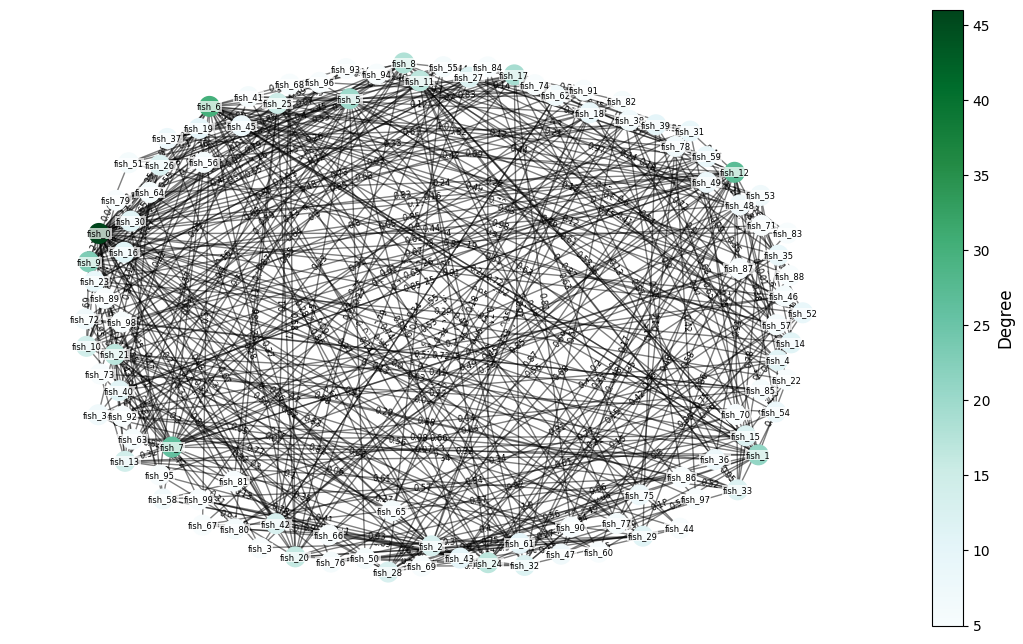

sbo: 852.7542798924693
sso: 1088.5267037733863


ZeroDivisionError: float division by zero

In [17]:
%%time
random.seed(42)

for run in range(1):
    model = Market_Model(N_agents = 100, Price = 10)
    
    N_steps = 1000
    progress = 100
    for step in range(N_steps):
        if step >= progress:
            print(f'progress: {progress}/{N_steps}')
            progress += 100
        model.step()

In [18]:
agent_vars = model.datacollector.get_agent_vars_dataframe()
model_vars = model.datacollector.get_model_vars_dataframe()

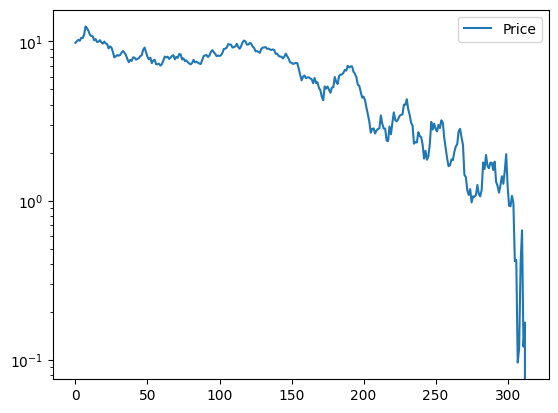

In [19]:
model_vars.plot();
plt.yscale('log')

In [96]:
model_vars.to_csv('model_vars.csv')
agent_vars.to_csv('agent_vars.csv')

**Observations:**
* Network is initialized with a barabasi-albert network with preferential attachment.
* Now agents can order a float quantity as order: ```self.order = 0.01 * self.cash / self.Price```. This already has a great impact on volatility clustering. Fishes alone can create bubbles.
* Randomized around 0.50 the trust threshold: ```self.trust_thr = round(0.50 * ( 1. + 0.5 * random.uniform(-1, 1) ), 2)```
* Randomized around 50 the cash threshold for survive_mode: ```self.cash_thr = round(50 * ( 1. + 0.5 * random.uniform(-1, 1) ), 2)```
* Only with fishes and without weights update we see that with $\mu = 0.001$ we have a perfect substitution for random traders in the old model. We still see a bit of volatility clustering.
* **Completed** updates of **trust weights** by using only binaries and float updates. If profits are synchronized then trust rises, if one grows and the other loses then trust goes down.